In [1]:
#IMPORT LIBRARIES
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from pyshred import DataManager, SHRED, SHREDEngine, DeviceConfig, PC_SHRED
import sys
import os
import pyshred
from Jakob_SHRED import Matser_utilz as utilz
from sklearn.preprocessing import MinMaxScaler



In [2]:
# DOMAIN DISCRETIZATION
def u_sol(t,x,n,Kn = 1,l = 1,c = 1):
        return Kn*np.sin(n*np.pi/l*(c*t))*np.sin(n*np.pi/l*x)
l = 1
c = 1
T = 2
N_t = 200
N_X = 400
t= np.linspace(0,T,N_t)
x = np.linspace(0,l,N_X)

def data_generate(n,t,x,l=1,c=1):
    data = np.zeros((len(t),len(x)))
    for i in range(len(t)):
        data[i,:] = u_sol(t[i],x,n =n,c=c, l = l)
    return data
data = data_generate(n=1,t=t,x=x)

In [19]:
lags = 40
x1 = 0.80
x2 = 0.05
x3 = 0.5
sensors = [np.argmin(x< x1),np.argmin(x< x2),np.argmin(x< x3)]

data_list = []
for n in range(1,8):
        data_list.append(data_generate(n=n,t=t,x=x))

for i in range(1,10):
    for j in range(1,10):
        if i < j:
            comb = (i,j)
            if comb != (2,4) and comb != (4,2):
                data_list.append(data_generate(n=i,t=t,x=x)+data_generate(n=j,t=t,x=x))
                print(comb)   
data_list.append(data_generate(n=1,t=t,x=x)+data_generate(n=2,t=t,x=x)+data_generate(n=3,t=t,x=x))
data_list.append(data_generate(n=1,t=t,x=x)+data_generate(n=3,t=t,x=x)+data_generate(n=4,t=t,x=x))
data_list.append(data_generate(n=1,t=t,x=x)+data_generate(n=3,t=t,x=x)+data_generate(n=5,t=t,x=x))


# # combinations = ((1,2),(2,3),(3,4),(1,4),(1,3))
# for comb in combinations:
#     data_list.append(data_generate(n=comb[0],t=t,x=x)+data_generate(n=comb[1],t=t,x=x))


X_data, full_states, scaler = utilz.data_prepare(data_list,lags,sensors)

data_save = {
    'X':X_data,
    'y':full_states,
    'scaler':scaler
}
np.save('Wave_data/data_1.npy',data_save)

data_for_test = [data_generate(n=2,t=t,x=x)+data_generate(n=4,t=t,x=x)]

X_for_test, y_for_test = utilz.trajectory_gen(data_for_test,lags,sensors)

for i in range(X_for_test.shape[0]):
    X_for_test[i] = scaler.transform(X_for_test[i,:,:].T).T
for_test = {
    'X':X_for_test,
    'y':y_for_test
}
np.save('Wave_data/data_1_for_test.npy',for_test)




(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 3)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 7)
(6, 8)
(6, 9)
(7, 8)
(7, 9)
(8, 9)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = np.load('Wave_data/data_1.npy',allow_pickle=True).item()

data['X'] = torch.tensor(data['X'],dtype = torch.float32,device = device)
data['y'] = torch.tensor(data['y'],dtype = torch.float32,device = device)

generator = torch.Generator().manual_seed(42)
data_all = utilz.SHREDdata(data)

train_dataset, val_dataset, test_dataset = data_all.split_data(train_ratio = 0.8, val_ratio=0.1, test_ratio=0.1, seed=42)



In [21]:
pc_shred = PC_SHRED(sequence_model="LSTM",
    decoder_model="MLP")

val_errors = pc_shred.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=600,
    batch_size= 512,
    verbose = True,
    lr = 0.0003,
    patience = 30
)

Fitting SHRED...
Epoch 1: Average training loss = 0.482221
Validation MSE (epoch 1): 0.477948
Epoch 2: Average training loss = 0.480558
Validation MSE (epoch 2): 0.476759
Epoch 3: Average training loss = 0.479874
Validation MSE (epoch 3): 0.475889
Epoch 4: Average training loss = 0.478457
Validation MSE (epoch 4): 0.472825
Epoch 5: Average training loss = 0.472683
Validation MSE (epoch 5): 0.460394
Epoch 6: Average training loss = 0.455689
Validation MSE (epoch 6): 0.436422
Epoch 7: Average training loss = 0.435988
Validation MSE (epoch 7): 0.416440
Epoch 8: Average training loss = 0.417842
Validation MSE (epoch 8): 0.403155
Epoch 9: Average training loss = 0.402868
Validation MSE (epoch 9): 0.381269
Epoch 10: Average training loss = 0.378963
Validation MSE (epoch 10): 0.353388
Epoch 11: Average training loss = 0.359575
Validation MSE (epoch 11): 0.339615
Epoch 12: Average training loss = 0.348235
Validation MSE (epoch 12): 0.328104
Epoch 13: Average training loss = 0.336210
Validation

In [30]:
# test123 = pc_shred._seq_model_outputs(test_dataset.X)

# pred = pc_shred.decoder(test123)

test1 = pc_shred.forward(data_all.X)

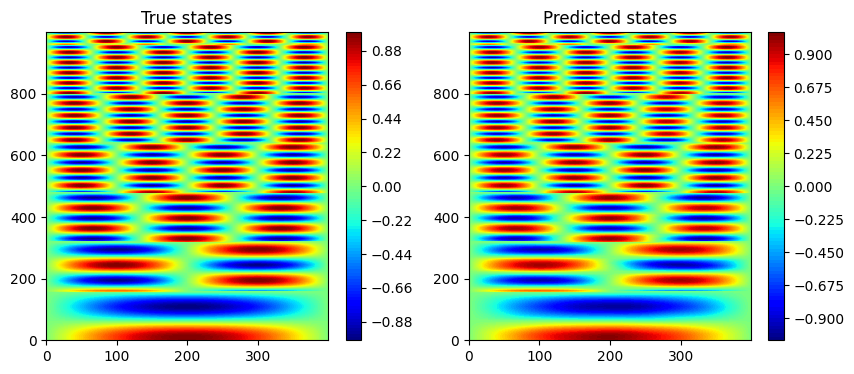

In [37]:
fig, ax = plt.subplots(1,2,figsize = (10,4))
cf1 = ax[0].contourf(data_all.Y.detach().cpu()[0:1000,:],100,cmap = 'jet')
cf2 = ax[1].contourf(test1.detach().cpu()[0:1000, :],100,cmap = 'jet')

ax[0].set_title('True states')
ax[1].set_title('Predicted states')
colorbar1 = fig.colorbar(cf1, ax=ax[0])
colorbar2 = fig.colorbar(cf2, ax=ax[1])


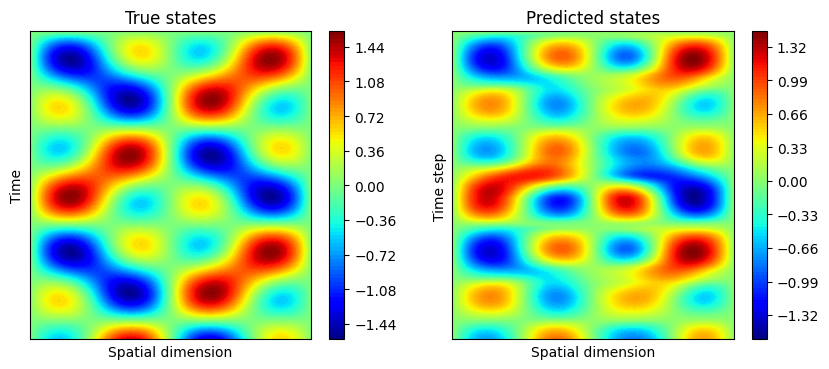

In [38]:
new_data = np.load('Wave_data/data_1_for_test.npy',allow_pickle=True).item()
new_data['X'] = torch.tensor(new_data['X'],dtype = torch.float32,device = device)
new_data['y'] = torch.tensor(new_data['y'],dtype = torch.float32,device = device)

data_all_for_test = utilz.SHREDdata(new_data)

latents_for_test = pc_shred._seq_model_outputs(new_data['X'])
pred_for_test = pc_shred.decoder(latents_for_test)

fig,ax = plt.subplots(1,2,figsize = (10,4))
cf1 = ax[0].contourf(new_data['y'].detach().cpu(),100,cmap = 'jet')
cf2 = ax[1].contourf(pred_for_test.detach().cpu(),100,cmap = 'jet')
ax[0].set_title('True states')
ax[1].set_title('Predicted states')
colorbar1 = fig.colorbar(cf1, ax=ax[0])
colorbar2 = fig.colorbar(cf2, ax=ax[1])
ax[0].set_ylabel('Time')
ax[0].set_xlabel('Spatial dimension')
ax[1].set_ylabel('Time step')
ax[1].set_xlabel('Spatial dimension')
#remove ticks from plots
ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()
